# AI Weather Prediction Project Notebook

#### Order
1. Decision Tree Regressor
2. XGBoost Regressor
3. XGBoost Classification
4. TensorFlow Neuro Network

#### Load Libraries to be used by all models. 

In [126]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

from sklearn.model_selection import train_test_split


plt.rcParams['figure.figsize']=(6,4)

In [127]:
df = pd.read_csv('weather_data_cleaned.csv')

In [128]:
df.columns

Index(['Location', 'Date_Time', 'Temperature_C', 'Temperature_F',
       'Humidity_pct', 'Precipitation_mm', 'Wind_Speed_kmh', 'Date', 'Time',
       'Military_Time', 'Precipitation_in', 'Rain_Category', 'Day_of_year'],
      dtype='object')

In [129]:
type('Temperature_C')

str

In [130]:
df.describe()

,Temperature_C,Temperature_F,Humidity_pct,Precipitation_mm,Wind_Speed_kmh,Precipitation_in,Day_of_year
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,14.779705,58.603468,60.021826,5.109639,14.997597,0.201149,69.946144
std,14.482559,26.068600,17.324020,2.947995,8.663558,0.116097,40.080596
min,-19.970000,-3.940000,30.000000,0.000000,0.000000,0.000000,1.000000
25%,2.270000,36.090000,45.010000,2.580000,7.490000,0.100000,35.000000
50%,14.780000,58.600000,60.020000,5.110000,14.990000,0.200000,70.000000
75%,27.270000,81.090000,75.040000,7.610000,22.510000,0.300000,105.000000
max,40.000000,104.000000,90.000000,14.970000,30.000000,0.590000,139.000000


## Decision Tree Regressor

In [131]:
# Write Decision Tree Regressor code here

## XGBoost Regressor 

In [132]:
# Establish X and y
y = df['Precipitation_in']
X = df.drop(columns=['Date_Time','Temperature_C','Precipitation_mm','Time','Military_Time','Rain_Category', 'Location', 'Date', 'Precipitation_in'])

In [133]:
# Check if the correct columns for X have been added
X.columns

Index(['Temperature_F', 'Humidity_pct', 'Wind_Speed_kmh', 'Day_of_year'], dtype='object')

In [134]:
# Prepare Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4700)

In [135]:
# Create XGBoost Regression Model
import xgboost
xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = 10 )

In [136]:
# Fit the model
xgb_r.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=True, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [137]:
# Determine Training R2 Score
prediction = xgb_r.predict(X_train)
training_r2 = r2_score(y_train, prediction )
training_r2

0.005821569290914708

In [138]:
# Determine Testing R2 Score
prediction = xgb_r.predict(X_test)
testing_r2 = r2_score(y_test, prediction )
testing_r2

0.0034962689806713465

### Test XGBoost Regressor at depths 1 through 10

In [139]:
training_r2 = []
testing_r2 = []

In [140]:
for depth in range(1, 11):
    xgb_r = xgboost.XGBRegressor(objective='reg:squarederror', enable_categorical=True, n_estimators = depth )
    xgb_r.fit(X_train, y_train)
    
    y_train_pred = xgb_r.predict(X_train)
    training_r2.append(r2_score(y_train, y_train_pred))
    
    y_test_pred = xgb_r.predict(X_test)
    testing_r2.append(r2_score(y_test, y_test_pred))
    

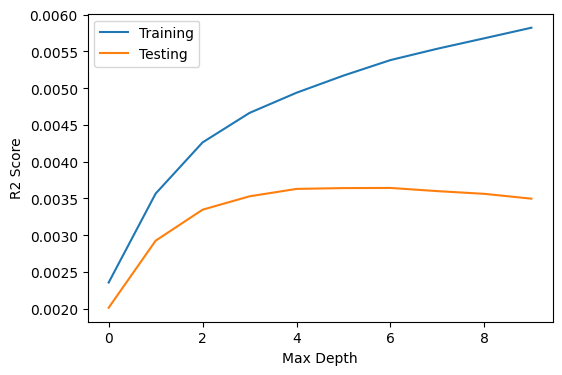

In [141]:
plt.plot(training_r2, label="Training")
plt.plot(testing_r2, label = "Testing")
plt.xlabel('Max Depth')
plt.ylabel('R2 Score')
plt.legend(loc = 'upper left')
plt.show()

## XGBoost Classifier

In [142]:
# Write XGB Classifier Code Here

## Tensor Flow Neuro Network

In [143]:
# Write Tensor Flow Neuro Network Code Here